# CSC 215 - Final Project

# Gender Classification with Deep Learning

## Khoi Hoang

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import time
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Helper function
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Manually load images

In [3]:
IMAGES_DIRECTORY = "C:/Users/hgdan/Downloads/lfw-deepfunneled/"

In [4]:
people = os.listdir(path=IMAGES_DIRECTORY)
print("There are {} people in the full lfw dataset.".format(len(people)))

There are 5749 people in the full lfw dataset.


In [5]:
image_array = []
for directory in os.listdir(IMAGES_DIRECTORY):
    image_dir = IMAGES_DIRECTORY + directory #go to sub directories
    for image in os.listdir(image_dir):
        image = plt.imread(os.path.join(image_dir, image))
        #image = cv2.resize(image, (100, 100))
        image_array.append(image)

In [6]:
image_array = np.array(image_array)
image_array.shape

(13233, 250, 250, 3)

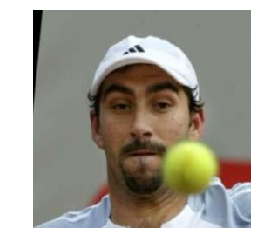

In [7]:
sample = 197

each = image_array[sample]

plt.figure()
plt.axis('off')
plt.imshow(each)
plt.show()

#### Making the gender labels for the output

In [8]:
df_male = pd.read_csv("gender_labels/male_names.txt")
df_female = pd.read_csv("gender_labels/female_names.txt")

In [9]:
df_female.head()

,Pics
0,Claudia_Coslovich_0001.jpg
1,Allison_Searing_0001
2,Elizabeth_Hill_0001.jpg
3,Erika_Reyes_0001.jpg
4,Tatiana_Shchegoleva_0001.jpg


In [10]:
# Helper function to convert the df into list of names for males or females
def gender_to_list(df):
    temp = df.values
    temp = temp.reshape(temp.shape[0],)
    
    res = []
    for each in temp:
        each = each.rsplit('_', 1)[0]
        res.append(each)
    
    return res

In [11]:
male = gender_to_list(df_male)
female = gender_to_list(df_female)

In [12]:
female[0:5]

['Claudia_Coslovich',
 'Allison_Searing',
 'Elizabeth_Hill',
 'Erika_Reyes',
 'Tatiana_Shchegoleva']

In [13]:
gender_target = []
for each in os.listdir(IMAGES_DIRECTORY): #iterate through the subdir
    if each in male:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('male')
    elif each in female:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('female')
    else:
        print(each)

In [14]:
gender_target = np.array(gender_target)
gender_target.shape

(13233,)

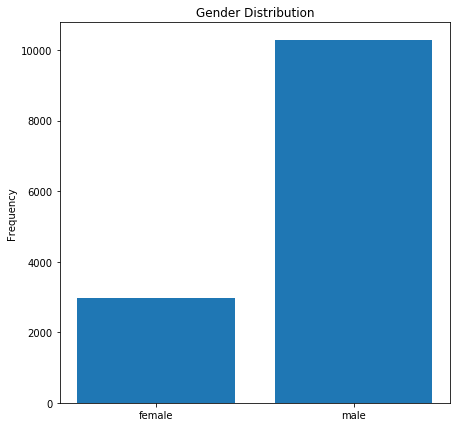

In [15]:
label, count_gender = np.unique(gender_target, return_counts=True)
y_pos = np.arange(2)
plt.figure(figsize=(7,7))
plt.bar(y_pos, count_gender, align='center')
plt.title("Gender Distribution")
plt.xticks(y_pos, label)
plt.ylabel("Frequency")
plt.show()

As we can see in the graph, the data is highly imbalanced. There are two ways to deal with imbalanced data:
  * Undersampling, we can reduce the number of male images to roughly 3k to balance the number of female images. However, this is not ideal because bigger data helps CNN train better
  * Oversampling, which is the technique I will apply in this project, is to increase the samples of imbalanced data. I will apply image augmentation on the female images to balance the male images

# Data balancing and Image Augmentation

In [16]:
female_images = []
male_images = []
for i in range(len(gender_target)):
    if gender_target[i] == 'female':
        female_images.append(image_array[i])
    else:
        male_images.append(image_array[i])
        
female_images = np.array(female_images)
male_images = np.array(male_images)
print(female_images.shape)
print(male_images.shape)

(2962, 250, 250, 3)
(10271, 250, 250, 3)


In [92]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

i=0
for batch in img_gen.flow(female_images, batch_size=1, 
                          save_to_dir="augmented",
                          save_format='jpg'):
    i+=1
    if i==7309:
        break
    

In [17]:
# read new augmented images
augmented_images = []
for image in os.listdir('augmented'):
    image = plt.imread(os.path.join('augmented/', image))
    augmented_images.append(image)

In [18]:
augmented_images = np.array(augmented_images)

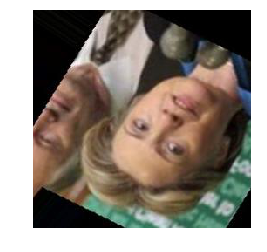

In [19]:
plt.figure()
plt.axis('off')
plt.imshow(augmented_images[197])
plt.show()

In [20]:
female_images = np.concatenate((female_images, augmented_images), axis=0)
female_images.shape

(10271, 250, 250, 3)

In [21]:
print("Number of male images: {}".format(male_images.shape[0]))
print("Number of female images: {}".format(female_images.shape[0]))

Number of male images: 10271
Number of female images: 10271


In [22]:
input_images = np.concatenate((male_images, female_images), axis=0)
output_label = np.zeros(input_images.shape[0])

In [23]:
# the first half is 0 (males), second half is 1 (females)
output_label[10271:] = 1

In order to train the data efficiently using the available memory, I resize the images to 100x100x3

In [24]:
# Resize the images
start = time.time()
input_images_resized = []
for each in input_images:
    each = cv2.resize(each, (100, 100))
    input_images_resized.append(each)

input_images_resized = np.array(input_images_resized)
print(input_images_resized.shape)
end = time.time()
print("Total time is {:0.2f}s".format(end-start))

(20542, 100, 100, 3)
Total time is 7.62s


# Deep CNN model

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, regularizers
from sklearn import metrics
from keras.optimizers import Adam
from keras.models import Model, load_model

Using TensorFlow backend.


In [26]:
x_train, x_test, y_train, y_test = train_test_split(input_images_resized, output_label, test_size=0.2, random_state=43)
#x_train, x_test, y_train, y_test = train_test_split(input_images, output_label, test_size=0.2, random_state=43)

In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16433, 100, 100, 3)
(16433,)
(4109, 100, 100, 3)
(4109,)


In [28]:
np.unique(y_test, return_counts=True)

(array([0., 1.]), array([2043, 2066], dtype=int64))

In [29]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [30]:
y_train

array([1., 0., 1., ..., 1., 1., 1.])

In [31]:
# One hot encode the gender
y_train_tf = keras.utils.to_categorical(y_train, 2)
y_test_tf = keras.utils.to_categorical(y_test, 2)

In [32]:
y_test_tf.shape

(4109, 2)

In [49]:
checkpointer = ModelCheckpoint(filepath="save/deepcnn.hdf5", verbose=0, save_best_only=True) # save best model
#input_shape = (250, 250, 3)
input_shape = (100, 100, 3)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape)) 
model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 96)        2688      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 96)        83040     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 96)        384       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 96)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 46, 46, 128)       110720    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 44, 44, 128)       147584    
__________

In [50]:
start = time.time()

history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],
                    verbose=1,epochs=50, batch_size=64, shuffle=True)      

end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 42s 3ms/step - loss: 2.9555 - acc: 0.6684 - val_loss: 2.0178 - val_acc: 0.8026
Epoch 2/50
13146/13146 [==============================] - 37s 3ms/step - loss: 1.9223 - acc: 0.8012 - val_loss: 1.6698 - val_acc: 0.8245
Epoch 3/50
13146/13146 [==============================] - 37s 3ms/step - loss: 1.4759 - acc: 0.8646 - val_loss: 1.3131 - val_acc: 0.8972
Epoch 4/50
13146/13146 [==============================] - 37s 3ms/step - loss: 1.1620 - acc: 0.8986 - val_loss: 1.0933 - val_acc: 0.8655
Epoch 5/50
13146/13146 [==============================] - 38s 3ms/step - loss: 0.9477 - acc: 0.9145 - val_loss: 0.9334 - val_acc: 0.8911
Epoch 6/50
13146/13146 [==============================] - 37s 3ms/step - loss: 0.7731 - acc: 0.9261 - val_loss: 0.7038 - val_acc: 0.9346
Epoch 7/50
13146/13146 [==============================] - 37s 3ms/step - loss: 0.6536 - acc: 0.9353 - val_loss: 0.6610 - val_acc:

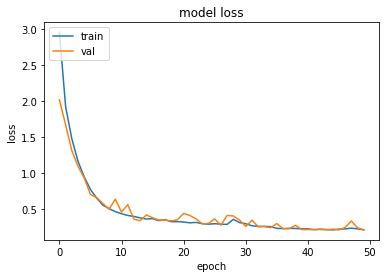

In [51]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
model = load_model('save/deepcnn.hdf5') # load weights from best model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 96)        2688      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 96)        83040     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 96)        384       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 96)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 48, 48, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 46, 46, 128)       110720    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 44, 44, 128)       147584    
__________

-----------------Convolutional Neural Network Report---------------
F1 score: 0.9749332251768377
Accuracy score: 0.9749330737405695
Confusion matrix: 
 [[2000   43]
 [  60 2006]]
Plotting confusion matrix


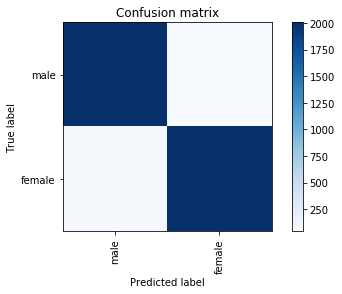

             precision    recall  f1-score   support

          0       0.97      0.98      0.97      2043
          1       0.98      0.97      0.97      2066

avg / total       0.97      0.97      0.97      4109



In [53]:
cnn_pred = model.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(y_true, cnn_pred)
cnn_cm = metrics.confusion_matrix(y_true, cnn_pred)
print("-----------------Convolutional Neural Network Report---------------")
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, cnn_pred))

# CNN Embedding

In [37]:
filepath = "save/cnn_embedding.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
input_shape = (100,100,3)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', name='embedding_features'))
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 96)        2688      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 96)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 128)       110720    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 67712)             0         
__________

In [38]:
start = time.time()

history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
cnn_embedding_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_embedding_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 23s 2ms/step - loss: 0.6826 - acc: 0.6156 - val_loss: 0.4235 - val_acc: 0.8156
Epoch 2/50
13146/13146 [==============================] - 19s 1ms/step - loss: 0.4120 - acc: 0.8051 - val_loss: 0.3031 - val_acc: 0.8658
Epoch 3/50
13146/13146 [==============================] - 20s 1ms/step - loss: 0.3231 - acc: 0.8491 - val_loss: 0.2361 - val_acc: 0.8966
Epoch 4/50
13146/13146 [==============================] - 20s 2ms/step - loss: 0.2739 - acc: 0.8785 - val_loss: 0.2305 - val_acc: 0.9026
Epoch 5/50
13146/13146 [==============================] - 20s 2ms/step - loss: 0.2338 - acc: 0.9000 - val_loss: 0.1860 - val_acc: 0.9273
Epoch 6/50
13146/13146 [==============================] - 20s 2ms/step - loss: 0.2056 - acc: 0.9142 - val_loss: 0.1778 - val_acc: 0.9288
Epoch 7/50
13146/13146 [==============================] - 20s 2ms/step - loss: 0.1902 - acc: 0.9220 - val_loss: 0.1938 - val_acc:

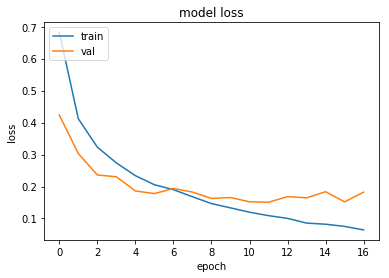

In [39]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
model = load_model('save/cnn_embedding.hdf5')
feature_model = Model(inputs=model.input, outputs=model.get_layer('embedding_features').output)

feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 98, 96)        2688      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 96)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 128)       110720    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 23, 128)       0         
__________

In [41]:
# Extracting the embedding features
embedding_features_train = feature_model.predict(x_train)
embedding_features_test = feature_model.predict(x_test)

In [42]:
embedding_features_test.shape

(4109, 1024)

# KNN model

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(embedding_features_train, y_train)

start = time.time()

y_pred_knn = knn.predict(embedding_features_test)

end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))

Total training time is 0.54 minute


-----------------**K-nearest neighbors Report**---------------

F1 score: 0.9403752532131231
Accuracy score: 0.9403747870528109
Confusion matrix: 
 [[1926  117]
 [ 128 1938]]
Plotting confusion matrix


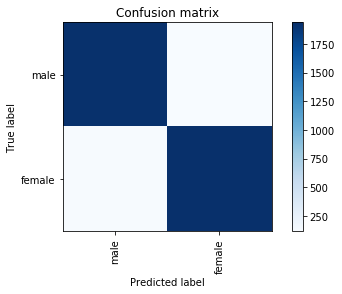

             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94      2043
        1.0       0.94      0.94      0.94      2066

avg / total       0.94      0.94      0.94      4109



In [48]:
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_accuracy = metrics.accuracy_score(y_test, y_pred_knn)
knn_cm = metrics.confusion_matrix(y_test, y_pred_knn)
printmd("-----------------**K-nearest neighbors Report**---------------")
print("F1 score: {}".format(knn_f1))
print("Accuracy score: {}".format(knn_accuracy))
print("Confusion matrix: \n", knn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(knn_cm, ['male', 'female'])
plt.show()

print(metrics.classification_report(y_test, y_pred_knn))

# Random Forest Model

In [49]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(criterion='entropy', max_depth=70, n_estimators=100)
start = time.time()

random_forest.fit(embedding_features_train, y_train)

end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Total training time is 0.25 minute


-----------------**Random Forest Report**---------------

F1 score: 0.9415913582987565
Accuracy score: 0.9415916281333658
Confusion matrix: 
 [[1936  107]
 [ 133 1933]]
Plotting confusion matrix


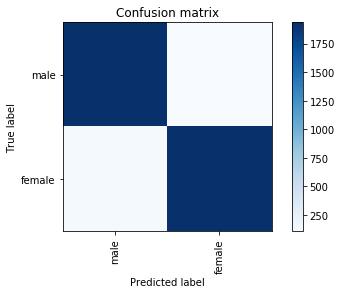

             precision    recall  f1-score   support

        0.0       0.94      0.95      0.94      2043
        1.0       0.95      0.94      0.94      2066

avg / total       0.94      0.94      0.94      4109



In [50]:
y_pred_forest = random_forest.predict(embedding_features_test)
random_forest_f1 = metrics.f1_score(y_test, y_pred_forest, average= "weighted")
random_forest_accuracy = metrics.accuracy_score(y_test, y_pred_forest)
random_forest_cm = metrics.confusion_matrix(y_test, y_pred_forest)
printmd("-----------------**Random Forest Report**---------------")
print("F1 score: {}".format(random_forest_f1))
print("Accuracy score: {}".format(random_forest_accuracy))
print("Confusion matrix: \n", random_forest_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(random_forest_cm, ['male', 'female'])
plt.show()

print(metrics.classification_report(y_test, y_pred_forest))

# SVM model

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf', 'poly'), 
              'C':(1, 10),'gamma': (1e-3, 1e-4,'auto')}

start = time.time()

clf = GridSearchCV(SVC(), parameters)
clf.fit(embedding_features_train, y_train)

end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))

Total training time is 80.19 minute


In [41]:
print("Best parameters: {}".format(clf.best_params_))

Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


-----------------**SVM Report**---------------

F1 score: 0.9330708151444981
Accuracy score: 0.9330737405694817
Confusion matrix: 
 [[1926  117]
 [ 158 1908]]
Plotting confusion matrix


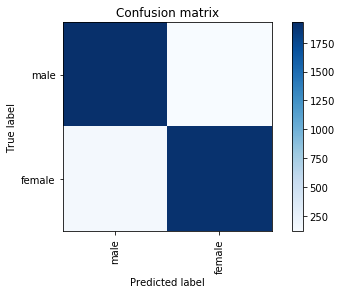

             precision    recall  f1-score   support

        0.0       0.92      0.94      0.93      2043
        1.0       0.94      0.92      0.93      2066

avg / total       0.93      0.93      0.93      4109



In [42]:
y_pred_svc = clf.predict(embedding_features_test)
svc_f1 = metrics.f1_score(y_test, y_pred_svc, average= "weighted")
svc_accuracy = metrics.accuracy_score(y_test, y_pred_svc)
svc_cm = metrics.confusion_matrix(y_test, y_pred_svc)
printmd("-----------------**SVM Report**---------------")
print("F1 score: {}".format(svc_f1))
print("Accuracy score: {}".format(svc_accuracy))
print("Confusion matrix: \n", svc_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(svc_cm, ['male', 'female'])
plt.show()

print(metrics.classification_report(y_test, y_pred_svc))

# Fully-connected Network model using CNN Embeddings

In [47]:
filepath = "save/nn_with_embedding.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Dense(2048, activation='relu', input_dim=embedding_features_train.shape[1],
               kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 4098      
Total para

In [48]:
start = time.time()

history = model.fit(embedding_features_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
nn_time = end-start
print("Total training time is {:0.2f} minute".format(nn_time/60.0))
model.load_weights("save/nn_with_embedding.hdf5")

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 6s 429us/step - loss: 1.7901 - acc: 0.9785 - val_loss: 1.2076 - val_acc: 0.9297
Epoch 2/50
13146/13146 [==============================] - 2s 190us/step - loss: 0.6039 - acc: 0.9829 - val_loss: 0.5824 - val_acc: 0.9361
Epoch 3/50
13146/13146 [==============================] - 3s 190us/step - loss: 0.3236 - acc: 0.9840 - val_loss: 0.4996 - val_acc: 0.9361
Epoch 4/50
13146/13146 [==============================] - 2s 187us/step - loss: 0.2322 - acc: 0.9843 - val_loss: 0.5758 - val_acc: 0.9115
Epoch 5/50
13146/13146 [==============================] - 3s 202us/step - loss: 0.1877 - acc: 0.9843 - val_loss: 0.4189 - val_acc: 0.9276
Epoch 6/50
13146/13146 [==============================] - 3s 193us/step - loss: 0.1792 - acc: 0.9839 - val_loss: 0.3598 - val_acc: 0.9416
Epoch 7/50
13146/13146 [==============================] - 3s 192us/step - loss: 0.1660 - acc: 0.9850 - val_loss: 0.4133 - v

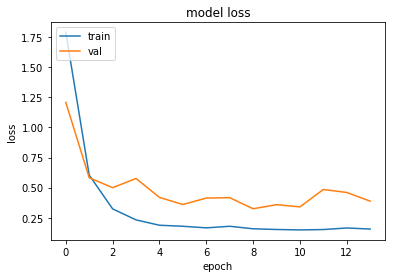

In [49]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

-----------------Neural Network Report---------------
F1 score: 0.9338042843343217
Accuracy score: 0.9338038452178146
Confusion matrix: 
 [[1915  128]
 [ 144 1922]]
Plotting confusion matrix


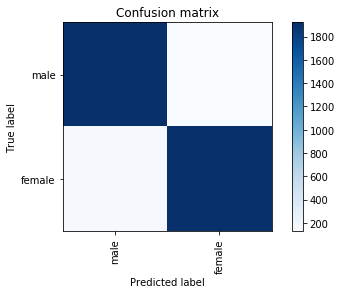

             precision    recall  f1-score   support

          0       0.93      0.94      0.93      2043
          1       0.94      0.93      0.93      2066

avg / total       0.93      0.93      0.93      4109



In [50]:
nn_with_embedding_pred = model.predict(embedding_features_test)
nn_with_embedding_pred = np.argmax(nn_with_embedding_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

nn_with_embedding_f1 = metrics.f1_score(y_true, nn_with_embedding_pred, average= "weighted")
nn_with_embedding_accuracy = metrics.accuracy_score(y_true, nn_with_embedding_pred)
nn_with_embedding_cm = metrics.confusion_matrix(y_true, nn_with_embedding_pred)
print("-----------------Neural Network Report---------------")
print("F1 score: {}".format(nn_with_embedding_f1))
print("Accuracy score: {}".format(nn_with_embedding_accuracy))
print("Confusion matrix: \n", nn_with_embedding_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(nn_with_embedding_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, nn_with_embedding_pred))

# CNN using CNN embeddings features

In [51]:
embedding_features_train_cnn = embedding_features_train.reshape(embedding_features_train.shape[0], embedding_features_train.shape[1], 1, 1)
embedding_features_test_cnn = embedding_features_test.reshape(embedding_features_test.shape[0], embedding_features_test.shape[1], 1, 1)

In [52]:
embedding_features_train_cnn.shape

(16433, 1024, 1, 1)

In [65]:
filepath = "save/cnn_with_embedding.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
learning_rate = 0.001
input_shape = (1024, 1, 1)
#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 1), strides=(1, 1), padding='same',
                 activation='relu', kernel_regularizer=keras.regularizers.l2(0.01),
                 input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1), strides=None, padding='same'))
model.add(Dropout(0.7)) 

model.add(Conv2D(96, kernel_size=(3, 1), strides=(1, 1), padding='same',
                 activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1), strides=None, padding='same'))
model.add(Dropout(0.7)) 

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(256, activation='relu', name='embedding_features'))
model.add(Dropout(0.7))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 1024, 1, 96)       384       
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024, 1, 96)       384       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 512, 1, 96)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 512, 1, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 512, 1, 96)        27744     
_________________________________________________________________
batch_normalization_16 (Batc (None, 512, 1, 96)        384       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 256, 1, 96)        0         
__________

In [66]:
start = time.time()

history = model.fit(embedding_features_train_cnn,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
cnn_embedding_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_embedding_time/60.0))
model.load_weights("save/cnn_with_embedding.hdf5")

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 7s 561us/step - loss: 0.9183 - acc: 0.9651 - val_loss: 0.9227 - val_acc: 0.9404
Epoch 2/50
13146/13146 [==============================] - 5s 348us/step - loss: 0.5553 - acc: 0.9818 - val_loss: 0.8919 - val_acc: 0.9407
Epoch 3/50
13146/13146 [==============================] - 5s 354us/step - loss: 0.3765 - acc: 0.9810 - val_loss: 0.5151 - val_acc: 0.9340
Epoch 4/50
13146/13146 [==============================] - 5s 353us/step - loss: 0.2338 - acc: 0.9820 - val_loss: 0.3614 - val_acc: 0.9395
Epoch 5/50
13146/13146 [==============================] - 5s 350us/step - loss: 0.1634 - acc: 0.9839 - val_loss: 0.3670 - val_acc: 0.9315
Epoch 6/50
13146/13146 [==============================] - 5s 350us/step - loss: 0.1243 - acc: 0.9846 - val_loss: 0.4523 - val_acc: 0.9121
Epoch 7/50
13146/13146 [==============================] - 5s 349us/step - loss: 0.1309 - acc: 0.9833 - val_loss: 0.2874 - v

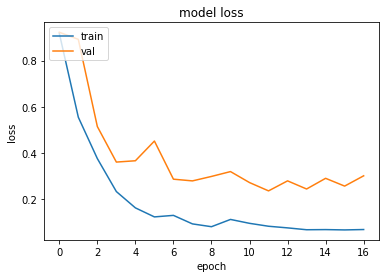

In [67]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

-----------------Neural Network Report---------------
F1 score: 0.9342909786248432
Accuracy score: 0.9342905816500365
Confusion matrix: 
 [[1911  132]
 [ 138 1928]]
Plotting confusion matrix


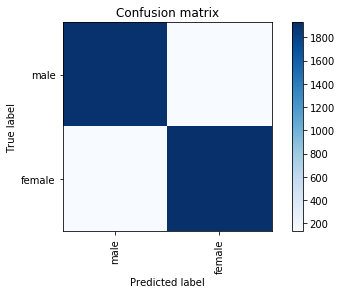

             precision    recall  f1-score   support

          0       0.93      0.94      0.93      2043
          1       0.94      0.93      0.93      2066

avg / total       0.93      0.93      0.93      4109



In [68]:
cnn_with_embedding_pred = model.predict(embedding_features_test_cnn)
cnn_with_embedding_pred = np.argmax(cnn_with_embedding_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_with_embedding_f1 = metrics.f1_score(y_true, cnn_with_embedding_pred, average= "weighted")
cnn_with_embedding_accuracy = metrics.accuracy_score(y_true, cnn_with_embedding_pred)
cnn_with_embedding_cm = metrics.confusion_matrix(y_true, cnn_with_embedding_pred)
print("-----------------Neural Network Report---------------")
print("F1 score: {}".format(cnn_with_embedding_f1))
print("Accuracy score: {}".format(cnn_with_embedding_accuracy))
print("Confusion matrix: \n", cnn_with_embedding_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_with_embedding_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, cnn_with_embedding_pred))

# Convolutional Autoencoder

In this section, I will use an autoencoder to extract important features from the images. 

In [45]:
filepath = "save/cnn_autoencoder.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

input_size = (100, 100, 3)

input_image = Input(shape=input_size)

# Encoder
x = Conv2D(128, (5, 5), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)


# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), padding='same')(x)

autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 128)     9728      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 64)        73792     
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 64)        36928     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 50, 50, 64)        0         
__________

In [47]:
start = time.time()

history = autoencoder.fit(x_train,x_train, validation_data=(x_test, x_test), callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=128, shuffle=True)    

end = time.time()
autoencoder_time = end-start
print("Total training time is {:0.2f} minute".format(autoencoder_time/60.0))

Train on 16433 samples, validate on 4109 samples
Epoch 1/50
16433/16433 [==============================] - 32s 2ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 2/50
16433/16433 [==============================] - 32s 2ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 3/50
16433/16433 [==============================] - 32s 2ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/50
16433/16433 [==============================] - 32s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/50
16433/16433 [==============================] - 32s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/50
16433/16433 [==============================] - 32s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/50
16433/16433 [==============================] - 31s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/50
16433/16433 [==============================] - 32s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 00008: early stopping
Total training time is 4.24 minute


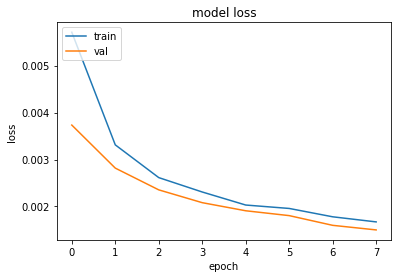

In [48]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [52]:
model = load_model('save/cnn_autoencoder.hdf5')
encoder_feature = Model(inputs=model.input, outputs=model.get_layer('encoded_layer').output)

encoder_feature.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 128)     9728      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 64)        73792     
_________________________________________________________________
encoded_layer (MaxPooling2D) (None, 25, 25, 64)        0         
Total params: 83,520
Trainable params: 83,520
Non-trainable params: 0
_________________________________________________________________


In [53]:
autoencoder_features_train = encoder_feature.predict(x_train)
autoencoder_features_test = encoder_feature.predict(x_test)

In [57]:
autoencoder_features_train.shape

(16433, 25, 25, 64)

# CNN with autoencoder extracted features

In [62]:
filepath = "save/cnn_with_autoencoder.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
input_shape = (25, 25, 64)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 1), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu', name='embedding_features'))
model.add(Dropout(0.35))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 23, 23, 96)        55392     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 9, 9, 128)         110720    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 9, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 9, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
__________

In [63]:
start = time.time()

history = model.fit(autoencoder_features_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
cnn_time = end-start
print("Total training time is {:0.2f} minute".format(cnn_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 6s 440us/step - loss: 0.4088 - acc: 0.7935 - val_loss: 0.2697 - val_acc: 0.8841
Epoch 2/50
13146/13146 [==============================] - 5s 368us/step - loss: 0.2396 - acc: 0.9007 - val_loss: 0.1836 - val_acc: 0.9221
Epoch 3/50
13146/13146 [==============================] - 5s 355us/step - loss: 0.1989 - acc: 0.9174 - val_loss: 0.1636 - val_acc: 0.9315
Epoch 4/50
13146/13146 [==============================] - 5s 357us/step - loss: 0.1654 - acc: 0.9334 - val_loss: 0.1318 - val_acc: 0.9492
Epoch 5/50
13146/13146 [==============================] - 5s 358us/step - loss: 0.1462 - acc: 0.9426 - val_loss: 0.1310 - val_acc: 0.9507
Epoch 6/50
13146/13146 [==============================] - 5s 369us/step - loss: 0.1295 - acc: 0.9494 - val_loss: 0.1230 - val_acc: 0.9513
Epoch 7/50
13146/13146 [==============================] - 5s 364us/step - loss: 0.1188 - acc: 0.9517 - val_loss: 0.1271 - v

-----------------**Convolutional Neural Network Report**---------------

F1 score: 0.9501082746210945
Accuracy score: 0.9501095156972499
Confusion matrix: 
 [[1958   85]
 [ 120 1946]]
Plotting confusion matrix


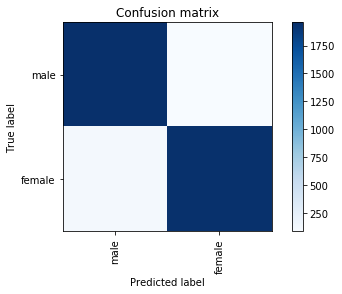

             precision    recall  f1-score   support

          0       0.94      0.96      0.95      2043
          1       0.96      0.94      0.95      2066

avg / total       0.95      0.95      0.95      4109



In [64]:
cnn_autoencoder_pred = model.predict(autoencoder_features_test)
cnn_autoencoder_pred = np.argmax(cnn_autoencoder_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_autoencoder_f1 = metrics.f1_score(y_true, cnn_autoencoder_pred, average= "weighted")
cnn_autoencoder_accuracy = metrics.accuracy_score(y_true, cnn_autoencoder_pred)
cnn_autoencoder_cm = metrics.confusion_matrix(y_true, cnn_autoencoder_pred)
printmd("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_autoencoder_f1))
print("Accuracy score: {}".format(cnn_autoencoder_accuracy))
print("Confusion matrix: \n", cnn_autoencoder_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_autoencoder_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, cnn_autoencoder_pred))

# Transfer learning with VGG16

In [69]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))

In [70]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [66]:
vgg16.output_shape[1:]

(3, 3, 512)

In [71]:
learning_rate = 0.001

for layer in vgg16.layers:
    layer.trainable = False
    
custom_model = Sequential()
custom_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
#custom_model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
#custom_model.add(Dropout(0.5))
#custom_model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
#custom_model.add(Dropout(0.5))
custom_model.add(Dense(y_train_tf.shape[1], activation='softmax'))

model = Model(inputs=vgg16.input, outputs=custom_model(vgg16.output))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [72]:
x_train.shape

(16433, 100, 100, 3)

In [73]:
filepath = "save/vgg16_transfer.hdf5"
checkpointer = ModelCheckpoint(filepath, verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

start = time.time()

history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    

end = time.time()
vgg16_time = end-start
print("Total training time is {:0.2f} minute".format(vgg16_time/60.0))

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 31s 2ms/step - loss: 0.3146 - acc: 0.8625 - val_loss: 0.2316 - val_acc: 0.9109
Epoch 2/50
13146/13146 [==============================] - 28s 2ms/step - loss: 0.2161 - acc: 0.9165 - val_loss: 0.2077 - val_acc: 0.9179
Epoch 3/50
13146/13146 [==============================] - 28s 2ms/step - loss: 0.1892 - acc: 0.9256 - val_loss: 0.2065 - val_acc: 0.9154
Epoch 4/50
13146/13146 [==============================] - 28s 2ms/step - loss: 0.1755 - acc: 0.9312 - val_loss: 0.2011 - val_acc: 0.9172
Epoch 5/50
13146/13146 [==============================] - 28s 2ms/step - loss: 0.1613 - acc: 0.9372 - val_loss: 0.1867 - val_acc: 0.9303
Epoch 6/50
13146/13146 [==============================] - 28s 2ms/step - loss: 0.1518 - acc: 0.9416 - val_loss: 0.1828 - val_acc: 0.9267
Epoch 7/50
13146/13146 [==============================] - 28s 2ms/step - loss: 0.1416 - acc: 0.9471 - val_loss: 0.1854 - val_acc:

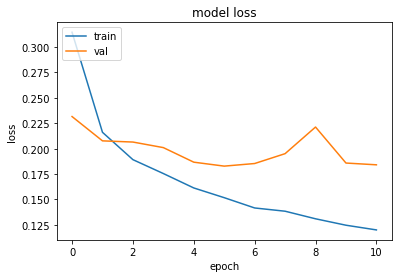

In [74]:
# plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

-----------------**Transfer Learning Report**---------------

F1 score: 0.926502189299758
Accuracy score: 0.9265027987344853
Confusion matrix: 
 [[1906  137]
 [ 165 1901]]
Plotting confusion matrix


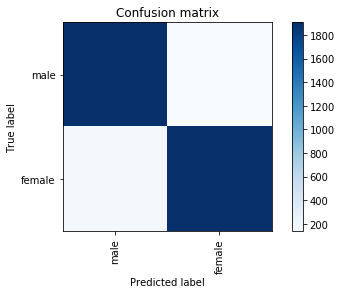

             precision    recall  f1-score   support

          0       0.92      0.93      0.93      2043
          1       0.93      0.92      0.93      2066

avg / total       0.93      0.93      0.93      4109



In [75]:
model.load_weights("save/vgg16_transfer.hdf5")
vgg16_transfer_pred = model.predict(x_test)
vgg16_transfer_pred = np.argmax(vgg16_transfer_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

vgg16_transfer_f1 = metrics.f1_score(y_true, vgg16_transfer_pred, average= "weighted")
vgg16_transfer_accuracy = metrics.accuracy_score(y_true, vgg16_transfer_pred)
vgg16_transfer_cm = metrics.confusion_matrix(y_true, vgg16_transfer_pred)
printmd("-----------------**Transfer Learning Report**---------------")
print("F1 score: {}".format(vgg16_transfer_f1))
print("Accuracy score: {}".format(vgg16_transfer_accuracy))
print("Confusion matrix: \n", vgg16_transfer_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(vgg16_transfer_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, vgg16_transfer_pred))